# Image Classification with PyTorch: Transfer learning 

[Pablo Carballeira] (http://dymas.ii.uam.es/webvpu/gti/user/186/), Escuela Politecnica Superior, Universidad Autónoma de Madrid.

Parts of this code have been adapted from then work of Kevin McGuinness (http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University, and the work of Ben Trevett (https://github.com/bentrevett), Heriot-Watt University

You can find documentation about working in Colab here (https://colab.research.google.com/notebooks/intro.ipynb)

---

This lab will investigate the use of transfer learning for a simple binary classification problem. We will work with the "Alien vs Predator" dataset that that originally comes from a [Kaggle competition](https://www.kaggle.com/pmigdal/alien-vs-predator-images). The task is to classify images as containing either the Alien creature from the Ridley Scott movie, or the Predator creature from the 1987 action classic Predator starring Arnold Schwarzenegger.

![AVP](https://crowdcast-prod.imgix.net/-Kab5fihhH1Q3R92MsOJ/event-cover-4763?w=800)


The dataset contains around 700 training examples and 200 validation examples, which are evenly balanced between the classes. However, 700 examples is quite a small dataset when comes to deep learning, and training a neural network from scratch (from a random initialization) would **overfit**.

This notebook will look at simple transfer learning techniques:
- Using a pretrained network **"off-the-shelf"** as a feature extractor. 
- **Fine tuning** a pretrained network for the new task.

In addition to the accuracy results, we will look at the t-SNE representations of the trained from scratch, pre-trained and fine-tuned features to understand their capacity to separate both classes



# Instructions

Anywhere you see a **???** in the code below, fill in in with the correct code.

# Import packages


Find the PyTorch docs at https://pytorch.org/docs/stable/index.html 

Tutorials: https://pytorch.org/tutorials/

In [1]:
import time
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import decomposition
from sklearn import manifold

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.datasets.utils import download_file_from_google_drive
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Enable GPU acceleration

Open to the Edit menu and select *Notebook settings* and check that *GPU* is selected under hardware accelerator.


In [2]:
# make sure to enable GPU acceleration!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


We set the random seed so all of our experiments can be reproduced.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Dataset download

Here we will use the "Alien vs Predator" dataset, which was originally taken from a [Kaggle competition](https://www.kaggle.com/pmigdal/alien-vs-predator-images). You can download it using this [Google Drive link](https://drive.google.com/file/d/1BTI5b1vJe36Jnn10USMND84TaWtACBae/view?usp=sharing). Here I use a utility function from PyTorch to download it directly from Google Drive.

In [4]:
download_file_from_google_drive(
    '1BTI5b1vJe36Jnn10USMND84TaWtACBae', 'data', 'avp.tar')

Extract the data and remove the tar file

In [5]:
!rm - rf data/avp
!cd data & & tar xf avp.tar
!rm data/avp.tar
!ls data/avp

train  valid


# Create the dataset

We will use the `ImageFolder` class to create the dataset. This works whenever we have a folder with subfolders, each of which represents a class. You can explore the `./content/data/avp` folder to check the structure of directories


First, let's take a look at some examples from the training set, to see how these images look like

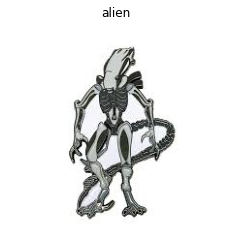

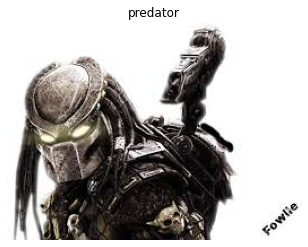

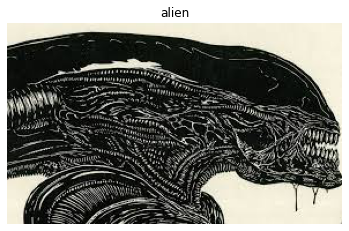

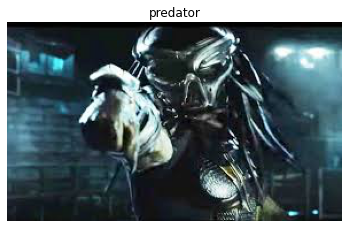

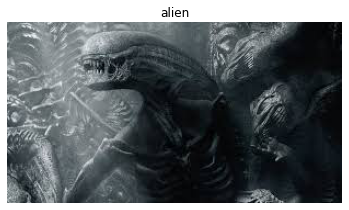

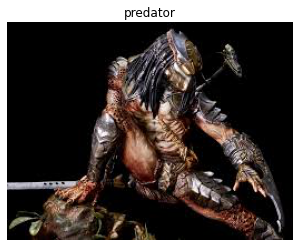

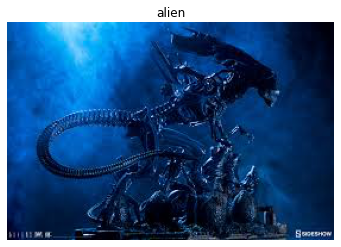

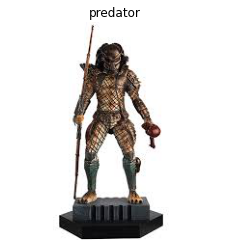

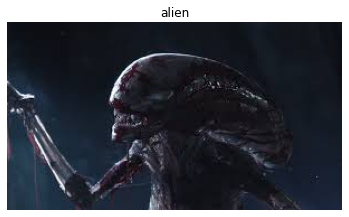

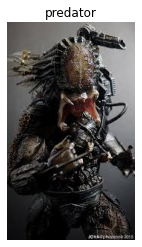

In [6]:
visual_train_set = ImageFolder('data/avp/train')
for i in range(5):
    plt.figure()
    plt.imshow(visual_train_set[i][0])
    plt.title(visual_train_set.classes[visual_train_set[i][1]])
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(visual_train_set[i+400][0])
    plt.title(visual_train_set.classes[visual_train_set[i+400][1]])
    plt.axis('off')
    plt.show()

We can see that this dataset is composed by images with different sizes and aspect ratios. We have to take this into account when creating the training and validation samples, as CNNs are usually designed for square images of fixed-size.

# Define the transformations

Here, we specify the set of transforms to be applied to the data. In addition to normalization, we apply image resizing and cropping to adapt the sizes of the images to the input of the CNN. For the time being, we are going to:
* resize the images by resizing the smallest dimension to 192 pixels (maintaining the aspect ratio), and
* take a  192x192 crop in from the image center.

Later, we will see more efficient ways to do this image cropping in the training and validation data. 

In [7]:
# Resize image and take a center crop. Check torchvision help to find the correct functions
train_transform = transforms.Compose([
    transforms.Resize(192),
    transforms.CenterCrop(192),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# apply, the same transformation to the validation data
valid_transform = transforms.Compose([
    transforms.Resize(192),
    transforms.CenterCrop(192),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Create training and validation sets using ImageFolder, and applying the
# transformation defined above
train_set = ImageFolder('data/avp/train', transform=train_transform)
valid_set = ImageFolder('data/avp/valid', transform=valid_transform)

# Create training and validation loaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False)

# save useful information
classes = valid_set.classes

In [8]:
print(f'train samples: {len(train_set)}  validation samples: {len(valid_set)}')

train samples: 694  validation samples: 200


# Training from scratch

First of all, let's see what happens if we train a CNN from scratch using the Alien vs Predator dataset.

Let's use the ResNet-50 model described by Kaiming He in his seminal paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). We will load the model, with random weights, and take a look at its layers

## Load the model and modify last FC layer

In [ ]:
# create a resnet50 model as before but do NOT load pre-trained weights
model = models.resnet50(pretrained=False)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

This model architecture is defined to be trained in the ImageNet dataset (as in the vast majority of cases). Therefore, the last FC layer is set to output scores for the 1000 classes of the ImageNet dataset. The first thing we need to do is to change the last FC layer so it outputs the scores of our two classes (Alien and Predator)

In [ ]:
# Replace the fc layer of the model with a FC layer of appropriate size
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))
model.to(device)

## Training the model

Let's define the training functions ...

In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
def save_checkpoint(optimizer, model, epoch, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [11]:
!mkdir - p checkpoints

In [12]:
def train_for_epoch(optimizer):

    # put the model in training mode
    model.train()

    train_losses = []

    for batch, target in train_loader:

        # data to GPU
        batch = batch.to(device)
        target = target.to(device)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        predictions = model(batch)

        # calculate loss
        loss = criterion(predictions, target)

        # backward pass
        loss.backward()

        # parameter update
        optimizer.step()

        # track loss
        train_losses.append(float(loss.item()))

    train_losses = np.array(train_losses)
    train_loss = np.mean(train_losses)

    return train_loss


def validate():
    model.eval()

    valid_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch, target in valid_loader:

            # move data to the device
            batch = batch.to(device)
            target = target.to(device)

            # make predictions
            predictions = model(batch)

            # calculate loss
            loss = criterion(predictions, target)

            # track losses and predictions
            valid_losses.append(float(loss.item()))
            y_true.extend(target.cpu().numpy())
            y_pred.extend(predictions.argmax(dim=1).cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    valid_losses = np.array(valid_losses)

    # calculate validation accuracy from y_true and y_pred
    valid_accuracy = metrics.accuracy_score(y_true, y_pred)

    # calculate the mean validation loss
    valid_loss = np.mean(valid_losses)

    return valid_loss, valid_accuracy


# training loop
def train(epochs, optimizer, first_epoch=1):

    train_losses, valid_losses, valid_accs = [], [], []

    for epoch in range(first_epoch, epochs+first_epoch):

        # train
        train_loss = train_for_epoch(optimizer)

        # validation
        valid_loss, valid_acc = validate()

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        # print status
        print(f'[{epoch:02d}] train loss: {train_loss.mean():0.04f}  '
              f'valid loss: {valid_loss:0.04f}  '
              f'acc: {valid_acc:0.04f}')

        # save checkpoint
        save_checkpoint(optimizer, model, epoch,
                        f'checkpoints/avp_{epoch:03d}.pkl')

    return train_losses, valid_losses, valid_accs

... and train the network for 15 epochs

In [ ]:
# Create an SGD optimizer with learning rate 0.01 and momentum 0.9
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Now train the model using the above optimizer for 15 epochs
train_losses, valid_losses, valid_accs = train(15, optimizer)

[01] train loss: 5.7900  valid loss: 19.7855  acc: 0.5000
[02] train loss: 1.6002  valid loss: 951.7988  acc: 0.5000
[03] train loss: 1.1630  valid loss: 1578.6871  acc: 0.5000
[04] train loss: 1.0543  valid loss: 9.1310  acc: 0.5100
[05] train loss: 0.6387  valid loss: 0.8181  acc: 0.6050
[06] train loss: 0.6136  valid loss: 1.0131  acc: 0.6000
[07] train loss: 0.6167  valid loss: 1.5551  acc: 0.6800
[08] train loss: 0.5995  valid loss: 1.2626  acc: 0.6300
[09] train loss: 0.5656  valid loss: 0.6432  acc: 0.7300
[10] train loss: 0.6040  valid loss: 0.9313  acc: 0.6800
[11] train loss: 0.5432  valid loss: 1.5850  acc: 0.7200
[12] train loss: 0.5484  valid loss: 0.8366  acc: 0.7000
[13] train loss: 0.5384  valid loss: 0.5788  acc: 0.7000
[14] train loss: 0.4893  valid loss: 0.6786  acc: 0.7350
[15] train loss: 0.4754  valid loss: 0.6128  acc: 0.7200


## Plot the learning curves




In [13]:
def plot_learning_curves(train_losses, valid_losses, valid_accs, crop=False):
    epochs = range(1, len(train_losses) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    axs[0].plot(epochs, train_losses, '-o', label='Training loss')
    axs[0].plot(epochs, valid_losses, '-o', label='Validation loss')
    axs[1].plot(epochs, valid_accs, '-o',
                color='tab:orange', label='Validation acc')

    axs[0].legend()
    axs[0].set_title('Learning curves')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_xticks(epochs)
    if crop:
        axs[0].set_ylim(0, 5)

    axs[1].legend()
    axs[1].set_title('Validation accuracy evolution')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Acc')
    axs[1].set_xticks(epochs)

    plt.show()

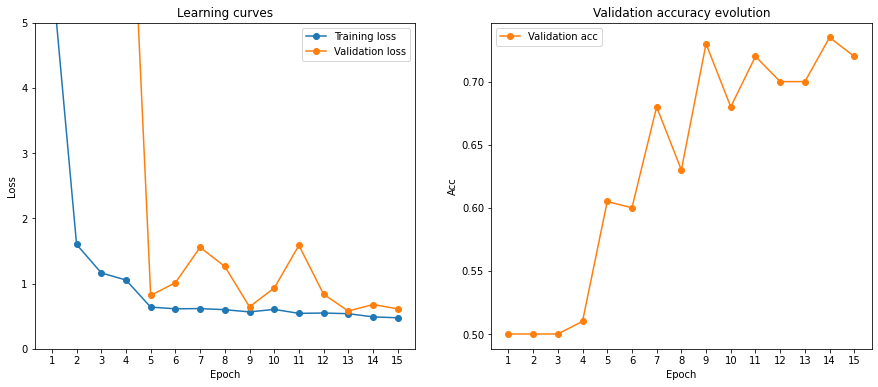

In [ ]:
plot_learning_curves(train_losses, valid_losses, valid_accs, crop=True)

We obtain an ~75% accuracy, which is not bad, but we will see that we can do much better using transfer learning

## Features trained from scratch: t-SNE representation

Let's take a look at the t-SNE representations of the features of the model. The features are obtained just before the FC layer (remember that the ResNet models include a Global Average Pooling layer followed by a single FC layer)

We want to check their representation capacity, in order to correctly separate both classes, and we will compare these features trained from scratch with the pre-trained and fine-tuned features. 

First, we define the functions for the t-SNE representation

In [14]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, labels

In [15]:
def plot_representations(data, labels, classes, n_images=None, C=1):
    from sklearn.svm import LinearSVC

    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    clf = LinearSVC(C=C, dual=False)
    clf.fit(data, labels)
    acc = clf.score(data, labels)
    b, w = clf.intercept_, clf.coef_[0]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    xmin, xmax = np.min(data[:, 0]), np.max(data[:, 0])
    ymin, ymax = np.min(data[:, 1]), np.max(data[:, 1])
    delta_x = (xmax - xmin)/10
    delta_y = (ymax - ymin)/10
    ax.set_ylim(ymin - delta_y, ymax + delta_y)
    x = np.array([xmin - delta_x, xmax + delta_x])
    svm = ax.plot(x, -(b + x*w[0])/w[1], color="green")
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, _ = scatter.legend_elements()
    legend = ax.legend(handles=handles + svm,
                       labels=classes + [f"acc {acc:.2f}"])

In [16]:
def get_tsne(data, n_components=2, n_images=None):

    if n_images is not None:
        data = data[:n_images]

    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

Get the features and labels of the samples of the validation set.

The first thing we need to do is to remove the last fully connected layer. An empty `nn.Sequential` layer can be used as an Identity mapping. 



In [ ]:
model.fc = nn.Sequential()

Now obtain the features and labels for the validation samples using the functions defined above

In [ ]:
valid_features, valid_labels = get_representations(model, valid_loader, device)

Plot the t-SNE representations

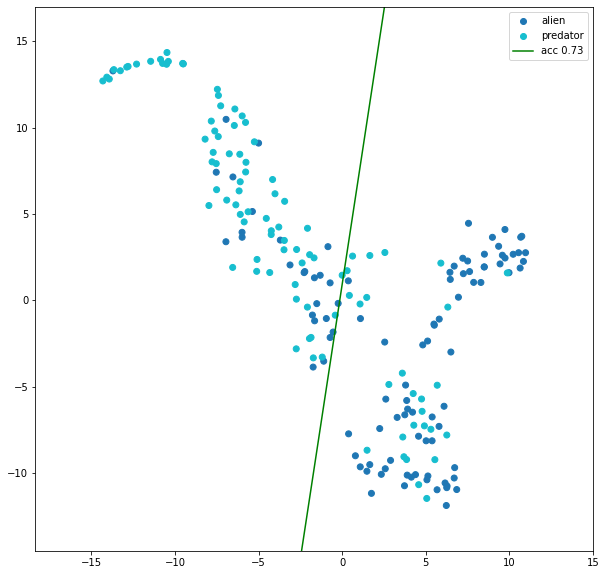

In [ ]:
N_IMAGES = 200

output_tsne_data = get_tsne(valid_features, n_images=N_IMAGES)
plot_representations(output_tsne_data, valid_labels,
                     valid_set.classes, n_images=N_IMAGES)

# Load a pre-trained ResNet model

Now let's load a pretrained ResNet50 model and try some transfer learning approaches


In [ ]:
model = models.resnet50(pretrained=True)
model.to(device)

# Off-the-shelf transfer learning

Let's start with "off-the-shelf" transfer learning. Here we will just use the pretrained model as a feature extractor and then train a linear classifier on top of these pretrained features.



## Pre-trained features: t-SNE representation

In [17]:
# use the code above to extract the pre-trained features (before FC layer) and plot
# its t-SNE representation in two dimensions. We recommend that you encapsulate the code
# in a single cell. You will reuse it later
def plot_tsne(model, loader, classes, n_images, C=1):
    model_orig_fc = model.fc
    model.fc = nn.Sequential()
    features, labels = get_representations(model, loader, device)
    output_tsne_data = get_tsne(features, n_images=n_images)
    plot_representations(output_tsne_data, labels,
                         classes, n_images=n_images, C=C)
    model.fc = model_orig_fc

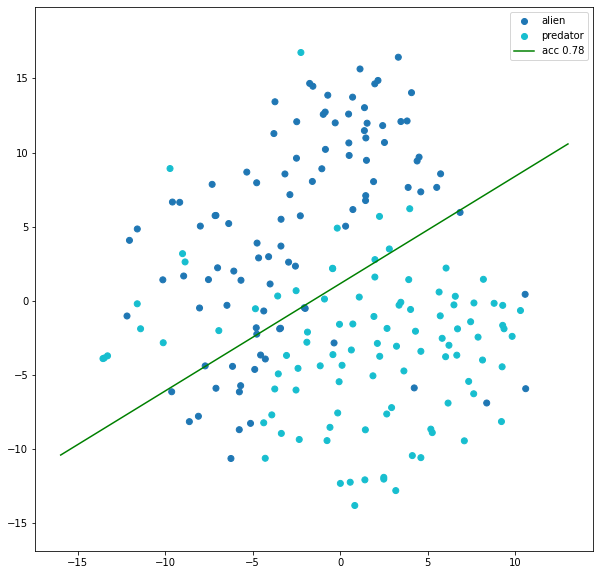

In [ ]:
plot_tsne(model, valid_loader, classes, N_IMAGES)

## Pre-trained features for training and validation data

In [ ]:
# extraction of training and validation features and labels
model.fc = nn.Sequential()
train_features, train_labels = get_representations(model, train_loader, device)
valid_features, valid_labels = get_representations(model, valid_loader, device)

print(f'train features are {train_features.shape}')
print(f'valid features are {valid_features.shape}')

train features are torch.Size([694, 2048])
valid features are torch.Size([200, 2048])


## Train a Support Vector Machine on top of the pre-trained features

Now, train a classical machine learning model on the representations. Let's try a **support vector machine** with a linear kernel as the classifier.

In [ ]:
from sklearn.svm import SVC

In [ ]:
# define a linear SMV classifier using SVC, and use the fit function to train it using the training features
clf = SVC(kernel='linear')
_ = clf.fit(train_features, train_labels)

In [ ]:
# make predictions for the validation feature using the classifier trained above
y_hat = clf.predict(valid_features)

In [ ]:
accuracy = metrics.accuracy_score(valid_labels, y_hat)
print(f'Accuracy: {accuracy:0.3f}')

Accuracy: 0.905


You should get 90.5% accuracy off the shelf: not bad! The validation set is balanced, so this is an excellent start.

In [ ]:
print(metrics.classification_report(
    valid_labels, y_hat, target_names=train_set.classes))

              precision    recall  f1-score   support

       alien       0.93      0.88      0.90       100
    predator       0.89      0.93      0.91       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



# Fine tuning

Let's try replace the last layer of the ResNet and fine tune it on the AVP dataset for a few epochs

## Modify the model

In [18]:
model = models.resnet50(pretrained=True)

# Freeze extraction layers so that gradients are not computed in backward pass
for param in model.parameters():
    param.requires_grad = False

# Replace fc with an fc layer of appropiate size (same as in training from scratch)
# Parameters of newly constructed modules have requires_grad=True by default
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))

model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


## Train (fine-tune) the model

Train the final layer for a few epochs to get it to a good place (remember, it starts off with random weights but the rest of the network has pre-trained weights from ImageNet)

In [19]:
final_layer_optimizer = optim.SGD(model.fc.parameters(), lr=0.01,
                                  momentum=0.9, weight_decay=1e-4)
train_losses, valid_losses, valid_accs = train(2, final_layer_optimizer)

[01] train loss: 0.6176  valid loss: 0.3717  acc: 0.7850
[02] train loss: 0.2603  valid loss: 0.4575  acc: 0.8350


Now fine tune whole network with a lower learning rate

In [20]:
# Un-freeze extraction network
for param in model.parameters():
    param.requires_grad = True

# train the model using the full network optimizer above for 10 epochs starting at epoch 3
full_network_optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_losses_full, valid_losses_full, valid_accs_full = train(
    10, full_network_optimizer, 3)

train_losses.extend(train_losses_full)
valid_losses.extend(valid_losses_full)
valid_accs.extend(valid_accs_full)

[03] train loss: 0.1648  valid loss: 0.1622  acc: 0.9150
[04] train loss: 0.0618  valid loss: 0.1483  acc: 0.9150
[05] train loss: 0.0109  valid loss: 0.1276  acc: 0.9300
[06] train loss: 0.0060  valid loss: 0.1238  acc: 0.9300
[07] train loss: 0.0061  valid loss: 0.1209  acc: 0.9300
[08] train loss: 0.0089  valid loss: 0.1199  acc: 0.9300
[09] train loss: 0.0033  valid loss: 0.1187  acc: 0.9300
[10] train loss: 0.0042  valid loss: 0.1186  acc: 0.9250
[11] train loss: 0.0050  valid loss: 0.1171  acc: 0.9250
[12] train loss: 0.0035  valid loss: 0.1175  acc: 0.9250


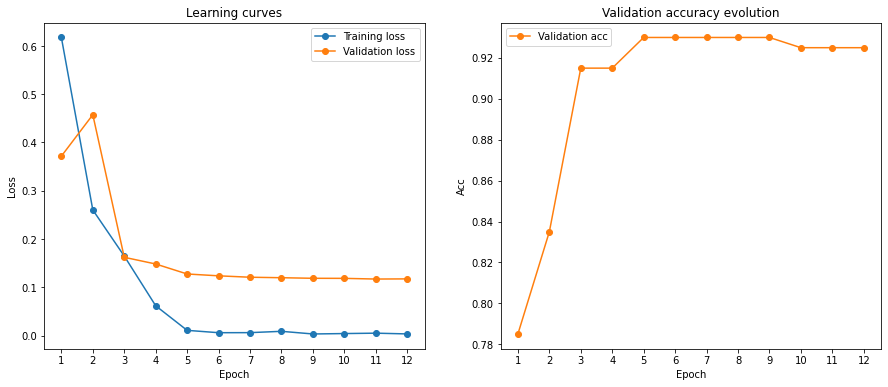

In [21]:
plot_learning_curves(train_losses, valid_losses, valid_accs)

Use the load_checkpoint function to load the model with the best performance

In [22]:
best_epoch = 9
load_checkpoint(None, model, f'checkpoints/avp_{best_epoch:03d}.pkl')

9

## Fine-tuned features: t-SNE representations 

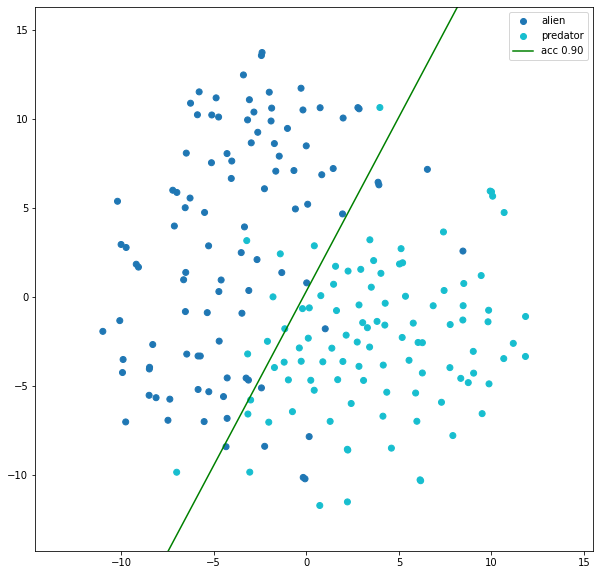

In [25]:
plot_tsne(model, valid_loader, classes, N_IMAGES)

# Data augmentation

Let's see if we can improve the performance of the fine-tuned model by applying some data augmentation to the training data. 

## Data augmentation transforms

Now we will define a set of transforms that will be applied to the data that implement basic data augmentation techniques: Random Cropping and Random Horizontal Flipping. 

The train transform is stochastic, which will help prevent overfitting when we fine-tune the model. The validation transform is deterministic, which ensures we will have consistent results on the same data.

In [ ]:
# define a transformation for the training data that resizes the image to 224x224 pixels,
# extracts a random 192x192 crop, and applies horizontal flip with 0.5 probability.
# Use the same data normalization we have used above
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(192),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# define a similar transformation for the validation data that resizes the image to 224x224 pixels,
# but now extracts a 192x192 crop from the image center
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(192),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Create training and validation sets using ImageFolder, and applying the
# transformation defined above
train_set = ImageFolder('data/avp/train', transform=train_transform)
valid_set = ImageFolder('data/avp/valid', transform=valid_transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
# Create a loader for the validation set, but disable shuffling of the validation data
# (it is unnecessary to shuffle validation data)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False)

In [ ]:
print(f'train samples: {len(train_set)}  validation samples: {len(valid_set)}')

train samples: 694  validation samples: 200


## Fine tuning

Use the previous code to fine-tune the pre-trained ResNet model, using the augmented training data, plot the learning graphs, and get the t-SNE representations of the features of the last layer

In [ ]:
model = models.resnet50(pretrained=True)

# Freeze extraction layers so that gradients are not computed in backward pass
for param in model.parameters():
    param.requires_grad = False

# Replace fc with an fc layer of appropiate size (same as in training from scratch)
# Parameters of newly constructed modules have requires_grad=True by default
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))

model.to(device)

In [ ]:
final_layer_optimizer = optim.SGD(model.fc.parameters(), lr=0.01,
                                  momentum=0.9, weight_decay=1e-4)
train_losses, valid_losses, valid_accs = train(2, final_layer_optimizer)

[01] train loss: 0.4657  valid loss: 0.2045  acc: 0.9100
[02] train loss: 0.1948  valid loss: 0.2025  acc: 0.9000


In [ ]:
# Un-freeze extraction network
for param in model.parameters():
    param.requires_grad = True

# train the model using the full network optimizer above for 10 epochs starting at epoch 3
full_network_optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_losses_full, valid_losses_full, valid_accs_full = train(
    10, full_network_optimizer, 3)

train_losses.extend(train_losses_full)
valid_losses.extend(valid_losses_full)
valid_accs.extend(valid_accs_full)

[03] train loss: 0.1503  valid loss: 0.1501  acc: 0.9050
[04] train loss: 0.1230  valid loss: 0.1375  acc: 0.9200
[05] train loss: 0.0561  valid loss: 0.1258  acc: 0.9400
[06] train loss: 0.0428  valid loss: 0.1105  acc: 0.9500
[07] train loss: 0.0316  valid loss: 0.1072  acc: 0.9500
[08] train loss: 0.0283  valid loss: 0.1016  acc: 0.9450
[09] train loss: 0.0142  valid loss: 0.1016  acc: 0.9550
[10] train loss: 0.0114  valid loss: 0.0952  acc: 0.9550
[11] train loss: 0.0152  valid loss: 0.0906  acc: 0.9500
[12] train loss: 0.0130  valid loss: 0.0914  acc: 0.9550


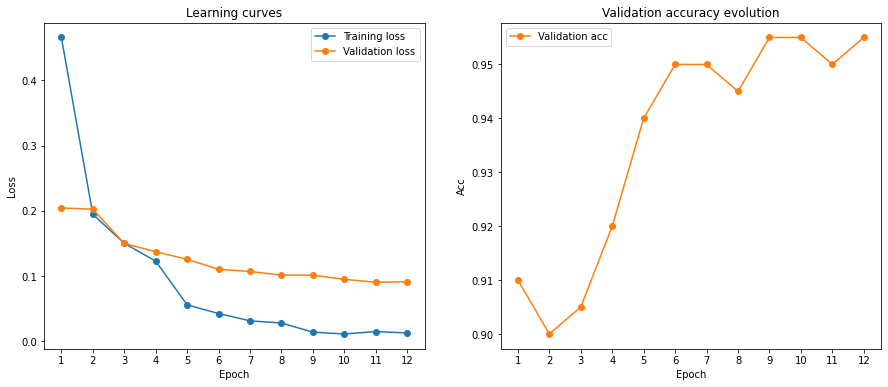

In [ ]:
plot_learning_curves(train_losses, valid_losses, valid_accs)

In [ ]:
best_epoch = 12
load_checkpoint(None, model, f'checkpoints/avp_{best_epoch:03d}.pkl')

12

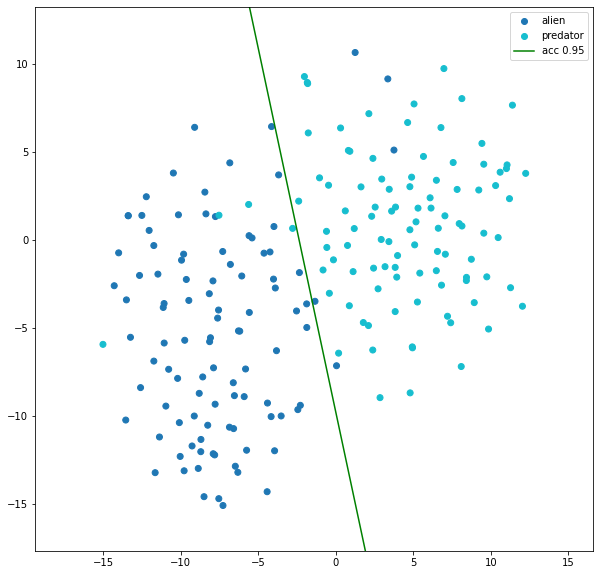

In [ ]:
plot_tsne(model, valid_loader, classes, N_IMAGES)